# Conversational analysis using Discursis

In this workshop, we'll look at how we can use Discursis to analyze conversational
data.

The dataset we'll use is the transcript of the National Press Club Leaders Debate
between Kevin Rudd and Tony Abbott, available at the [Parliament of Australia website](https://parlinfo.aph.gov.au/parlInfo/search/display/display.w3p;query=Id:%22media/pressrel/2658246%22) under a [CC BY-NC-ND 3.0 AU](https://creativecommons.org/licenses/by-nc-nd/3.0/au/)
Creative Commons license.

## Python setup

Discursis and the accompanying tools for conversation data are in the `atap_widgets` Python
package. We'll load the tools from this library, along with the other libraries we'll be using
for the analysis:

In [1]:
import os

# pandas: tools for data processing
import pandas as pd

# numpy: tools for numerical calculations
import numpy as np

pd.options.display.max_colwidth = 100
# Bokeh: interactive plots
from bokeh.io import output_notebook
from bokeh.models import ColorBar
from bokeh.plotting import figure, show
from bokeh.transform import linear_cmap

# networkx: graphs/networks
import networkx as nx

# matplotlib: another plotting library
from matplotlib import cm
import matplotlib.pyplot as plt

# This needs to be run to enable interactive bokeh plots
output_notebook()

# Individual tools from atap_widgets
from atap_widgets.conversation import (
    ConceptSimilarityModel,
    Conversation,
    EmbeddingModel,
)
from atap_widgets.plotting import ConversationPlot
from atap_widgets.concordance import (
    ConcordanceTable,
    ConcordanceWidget,
    prepare_text_df,
)

Loading BokehJS ...

In [2]:
# Create a results folder, if it doesn't already exist
os.makedirs("conversation_results", exist_ok=True)

## Loading the data

The conversation tools are designed to accept data as a `pandas` dataframe.
Each row in the dataframe should be an utterance in the conversation. There
should be a `"text"` column with the actual content of the utterance
and a `"speaker"` column identifying who is speaking. It also helps if we have a `"text_id"` column that gives a unique identifier for each utterance that
we can refer to.


Additional metadata columns that might be relevant to your particular dataset
will be imported into the conversation tool as-is. In this case we have an additional
`"role"` column identifying each person's role in the debate.

In [3]:
data = pd.read_excel("data/debate_clean.xlsx")
data.head()

,text_id,speaker,text,role
0,1,SPEERS,Good evening and welcome to the National Press Club election leaders' debate. Please put your h...,Journalist
1,2,PM,"This country of ours, Australia, is one of the best countries in the world. We have a strong an...",Labor
2,3,SPEERS,"Prime Minister, thank you. Tony Abbott I would like you now to make your opening remarks.",Journalist
3,4,ABBOTT,"Thanks very much, David. This debate is between Mr Rudd and me but the election is not about Mr...",Coalition
4,5,SPEERS,"Tony Abbott, Thank you very much for that. Now before we get to questions from my colleagues on...",Journalist


## Data exploration

Before carrying out conversational analysis, we can do some initial exploration of the data
to get an overview of it. We can do this with the tools that are built in to `pandas`,
rather than specialized language tools.

We can see how many times each person spoke during the debate:

In [4]:
print("Total utterances:", len(data))
data["speaker"].value_counts()

Total utterances: 118


SPEERS      47
ABBOTT      31
PM          29
HARTCHER     6
CURTIS       3
BENSON       2
Name: speaker, dtype: int64

And see how many times people in different roles spoke:

In [5]:
pd.crosstab(data["speaker"], data["role"], margins="columns")

role,Coalition,Journalist,Labor,All
speaker,,,,
ABBOTT,31,0,0,31
BENSON,0,2,0,2
CURTIS,0,3,0,3
HARTCHER,0,6,0,6
PM,0,0,29,29
SPEERS,0,47,0,47
All,31,58,29,118


We can use the `ConcordanceTable` tool to start looking at some key terms
in the conversation. Terms that might be relevant to a political debate
might be things like "economy" or "environment".

Before using the concordance tools, we need to use the `prepare_text_df()`
function to process the data, which applies some initial NLP processing.

In [6]:
data = prepare_text_df(data, text_column="text", id_column="text_id")

table = ConcordanceTable(data, keyword="economy", results_per_page=10)
table

We can update the search settings and display the table again:

In [7]:
table.keyword = "environment"
table

It seems the economy was a focus, but environmental issues were not a major feature of this debate.

If you have other ideas about relevant topics, you can use the 
`ConcordanceWidget` to search for them in real-time. If you've
found useful results, you can export them to Excel:

In [8]:
widget = ConcordanceWidget(data, results_per_page=10)
widget.show()

> ### What's the difference between ConcordanceWidget and ConcordanceTable?
>
> * `ConcordanceWidget` lets you search interactively, but the results won't be saved in the notebook
> * `ConcordanceTable` is non-interactive, but the results are saved in the notebook, so you
>   can share them easily

## Conversational analysis

In order to perform conversational analysis, we need to load our data into
a `Conversation` object. The `Conversation` object carries out some initial processing of the text,
which will be handled by a `spacy` language model. If you need to analyse
data for a non-English corpus, you can install a relevant [spacy model](https://spacy.io/usage/models).

In [9]:
conversation = Conversation(
    data=data,
    text_column="text",
    speaker_column="speaker",
    id_column="text_id",
    language_model="en_core_web_sm",
)
conversation

Conversation(118 utterances, 6 speakers, language_model='en_core_web_sm')

The `Conversation` object offers some basic functionality for accessing information about
the conversation:

In [10]:
conversation.n_speakers, conversation.n_utterances

(6, 118)

You can access the table of utterance data via `conversation.data` - this
is a `pandas` DataFrame like the original data but has some additional
information added:

In [11]:
conversation.data.head()

,text_id,speaker,text,role,spacy_doc
text_id,,,,,
1,1,SPEERS,Good evening and welcome to the National Press Club election leaders' debate. Please put your h...,Journalist,"( , Good, evening, and, welcome, to, the, National, Press, Club, election, leaders, ', debate, ...."
2,2,PM,"This country of ours, Australia, is one of the best countries in the world. We have a strong an...",Labor,"( , This, country, of, ours, ,, Australia, ,, is, one, of, the, best, countries, in, the, world,..."
3,3,SPEERS,"Prime Minister, thank you. Tony Abbott I would like you now to make your opening remarks.",Journalist,"( , Prime, Minister, ,, thank, you, ., Tony, Abbott, I, would, like, you, now, to, make, your, o..."
4,4,ABBOTT,"Thanks very much, David. This debate is between Mr Rudd and me but the election is not about Mr...",Coalition,"( , Thanks, very, much, ,, David, ., This, debate, is, between, Mr, Rudd, and, me, but, the, ele..."
5,5,SPEERS,"Tony Abbott, Thank you very much for that. Now before we get to questions from my colleagues on...",Journalist,"( , Tony, Abbott, ,, Thank, you, very, much, for, that, ., Now, before, we, get, to, questions, ..."


When we calculate conversational similarity below, the default method is based
on the most common terms in the data. We can check what these are:

In [12]:
conversation.get_most_common_terms(n=20)

['mr',
 'tax',
 'new',
 'abbott',
 'government',
 'people',
 'future',
 'economy',
 'years',
 'question',
 'country',
 'rudd',
 'productivity',
 'time',
 'australia',
 'minister',
 'change',
 'said',
 'going',
 'way']

We may want to treat some of these terms as **stopwords** so that they don't contribute to
the calculation of topic similarity. After adding these stopwords,
the changes should be applied in any new operations:

In [13]:
conversation.add_stopword("Mr")
conversation.add_stopword("said")

In [14]:
conversation.get_most_common_terms(n=20)

['tax',
 'new',
 'abbott',
 'government',
 'people',
 'future',
 'economy',
 'years',
 'question',
 'country',
 'rudd',
 'time',
 'australia',
 'productivity',
 'minister',
 'change',
 'going',
 'way',
 'national',
 'believe']

You can also access and export the full frequency table of terms. The `term_frequencies` table
is a `pandas` DataFrame, so we can export it to Excel easily:

In [15]:
term_frequencies = conversation.get_term_frequencies()
term_frequencies.to_excel("conversation_results/term_frequencies.xlsx", index=False)
term_frequencies

,term,frequency
1269,tax,61
860,new,48
51,abbott,44
584,government,43
924,people,42
...,...,...
850,necessary,1
340,criticised,1
852,needed,1
854,negativity,1


### Calculating similarity

In order to calculate similarity of terms and topics across the conversation,
we'll use the conceptual recurrence calculation from

> Angus, D., Smith, A. E., & Wiles, J. (2012). Human Communication as Coupled Time Series: Quantifying Multi-Participant Recurrence. IEEE Transactions on Audio, Speech, and Language Processing, 20(6), 1795–1807. https://doi.org/10.1109/TASL.2012.2189566

This method is implemented in `ConceptSimilarityModel`, which takes in a conversation
object and performs the similarity calculation on it. To match the method used in the article,
we'll use the top 50 key terms as the basis for concepts, which we set with the
`key_terms` argument, and use 3-sentence windows when counting which terms co-occur:

In [16]:
concept_model = ConceptSimilarityModel(
    conversation, key_terms=50, sentence_window_size=3
)
concept_model

ConceptSimilarityModel(key_terms=50, sentence_window_size=3

For convenience, we only need to call one function to get the utterance-to-utterance
similarity that will form the basis of the Discursis plot:

In [17]:
concept_similarity = concept_model.get_conversation_similarity()
print(concept_similarity.shape)
concept_similarity.iloc[:5, :5]

(118, 118)


text_id,1,2,3,4,5
text_id,,,,,
1,1.000000,0.408332,0.693234,0.308622,0.792809
2,0.408332,1.000000,0.328731,0.560468,0.440629
3,0.693234,0.328731,1.000000,0.084501,0.920332
4,0.308622,0.560468,0.084501,1.000000,0.200324
5,0.792809,0.440629,0.920332,0.200324,1.000000


However, if we need to, we can also access the concept vectors the similarity is based on:

In [18]:
concept_vectors = concept_model.get_concept_vectors()
print(concept_vectors.shape)
concept_vectors.iloc[:5, :]

(50, 118)


text_id,1,2,3,4,5,6,7,8,9,10,...,109,110,111,112,113,114,115,116,117,118
abbott,224.244469,89.071971,65.091867,46.081894,138.937046,22.355415,6.659147,63.630207,131.973754,15.154589,...,124.838932,20.073139,7.452381,30.385096,38.839786,69.051865,27.105891,217.576926,9.905434,61.119522
government,36.826037,201.714399,9.661247,133.954257,43.17319,47.99172,7.278212,114.012329,49.511366,24.098033,...,29.280331,48.937754,7.694698,27.392196,14.140756,72.300474,11.791169,293.140289,1.926848,163.902711
question,439.306556,68.471369,5.034484,34.193372,45.252081,24.686205,8.793864,57.683139,26.383184,14.471665,...,37.153173,41.919798,0.0,22.649408,10.314339,39.573042,5.874018,98.85574,2.42,52.953696
people,52.881114,185.454798,7.078047,175.122902,58.836817,97.689425,4.413158,65.472174,23.75025,30.314405,...,7.749272,27.564423,2.814815,10.09535,5.869557,47.363674,7.175604,363.015566,1.339954,125.006251
tax,50.119389,111.062354,10.605779,214.530098,55.649711,37.028777,7.478174,178.795403,111.29233,26.337133,...,15.032496,46.597781,1.245455,9.9621,3.177647,30.644561,8.02659,133.569905,5.069717,157.425802


Or the similarity between terms in the conversation (based on their co-occurrence):

In [19]:
term_similarity = concept_model.get_term_similarity_matrix()
print(term_similarity.shape)
term_similarity.loc[concept_model.key_terms, concept_model.key_terms].iloc[:5, :]

(1423, 1423)


,abbott,government,question,people,tax,years,time,rudd,minister,country,...,ago,look,debate,labor,cuts,better,like,come,way,strong
abbott,0.0,1.495342,2.42,0.830189,3.635854,0.878645,1.737892,1.359875,1.472727,0.211186,...,1.891626,0.512097,0.833333,2.891547,2.640351,0.365779,0.363636,0.693548,0.830508,0.403226
government,1.495342,0.0,0.805704,0.956209,2.812217,2.71978,1.004329,2.619749,1.194872,2.220779,...,6.096774,0.423611,0.919146,1.823529,1.273292,1.246154,1.493415,0.956466,3.046287,0.333333
question,2.42,0.805704,0.0,0.398619,2.59583,0.787582,3.197115,1.683871,0.179094,1.761364,...,2.495495,0.0,2.537037,1.420513,1.94386,0.0,0.613636,0.523452,0.0,0.0
people,0.830189,0.956209,0.398619,0.0,0.541872,0.98752,0.810169,0.926585,1.20802,1.769231,...,0.717268,0.819355,0.356421,2.177966,2.58477,1.774545,0.356421,1.698361,0.813333,1.608051
tax,3.635854,2.812217,2.59583,0.541872,0.0,1.068455,0.591346,2.643357,0.265795,0.702128,...,3.694444,1.998492,0.430976,1.998492,25.060976,0.612903,2.729167,0.0,0.745562,1.111111


All of these results are `pandas` DataFrames, so we can export them to Excel like we did above:

In [20]:
# The index for these tables contains important info, so include it
#   when exporting
concept_similarity.to_excel("conversation_results/debate_similarity.xlsx", index=True)
concept_vectors.to_excel("conversation_results/concept_vectors.xlsx", index=True)
term_similarity.to_excel("conversation_results/term_similarity.xlsx", index=True)

> #### Advanced usage
>
> This code is here to demonstrate that you can use the results
> from the conversation tools however you want, using standard
> tools like plotting libraries.
>
> However, the code requires some advanced knowledge of
> `pandas` - this level of knowledge isn't required
> for the rest of the workshop

In [21]:
term_similarity_data = (
    term_similarity.loc[concept_model.key_terms, concept_model.key_terms]
    .stack()
    .rename_axis(["term", "other"])
    .rename("similarity")
    .reset_index()
)
p = figure(
    title="Term similarity",
    x_range=concept_model.key_terms,
    y_range=concept_model.key_terms,
)
similarity_colours = linear_cmap("similarity", "Viridis256", 0, 1)
p.rect(
    x="term",
    y="other",
    width=1,
    height=1,
    fill_color=similarity_colours,
    source=term_similarity_data,
)
p.xaxis.major_label_orientation = "vertical"

legend = ColorBar(color_mapper=similarity_colours["transform"])
p.add_layout(legend, "right")
show(p)

## Topic recurrence metrics

Once we've calculated the conversational similarity, we can use it
to calculate related quantities, e.g. the **multi-participant
recurrence metrics** outlined in:

> Angus, D., Smith, A. E., & Wiles, J. (2012). Human Communication as Coupled Time Series: Quantifying Multi-Participant Recurrence. IEEE Transactions on Audio, Speech, and Language Processing, 20(6), 1795–1807. https://doi.org/10.1109/TASL.2012.2189566



and the **person-to-person (P2P)** and **group-to-group (G2G) recurrence** outlined in:

> Angus, D., & Wiles, J. (2018). Social semantic networks: Measuring topic management in discourse using a pyramid of conceptual recurrence metrics. Chaos: An Interdisciplinary Journal of Nonlinear Science, 28(8), 085723. https://doi.org/10.1063/1.5024809


### Multi-participant recurrence

The multi-participant recurrence metrics can be calculate for different combinations of:

* Time scale: short, medium or long
* Direction: forward or backward
* Speaker: self or other

You can calculate metrics one at a time. The results show the recurrence score
for each utterance in the conversation (identified by `text_id`):

In [22]:
conversation.get_topic_recurrence(
    similarity=concept_similarity,
    time_scale="short",
    direction="forward",
    speaker="self",
)

text_id
1      1.964037
2      1.356644
3      1.335775
4      0.585375
5      1.344656
         ...   
114    0.586422
115    0.703413
116         0.0
117         0.0
118         0.0
Length: 118, dtype: object

Or calculate them for all combinations. These results are returned in a format that's
easy to filter and query in `pandas`:

In [23]:
all_recurrences = conversation.get_all_topic_recurrences(similarity=concept_similarity)
all_recurrences.head()

,time_scale,direction,speaker,text_id,score
0,short,forward,self,1,1.964037
1,short,forward,self,2,1.356644
2,short,forward,self,3,1.335775
3,short,forward,self,4,0.585375
4,short,forward,self,5,1.344656


If you want to view them side-by-side you can do:

In [24]:
all_recurrences.pivot(
    index="text_id", columns=["time_scale", "direction", "speaker"], values="score"
)

/opt/anaconda3/envs/atap/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


time_scale     short                                  medium            \
direction    forward            backward             forward             
speaker         self     other      self     other      self     other   
text_id                                                                  
1           1.964037  1.026876       0.0       0.0  2.870986  1.966943   
2           1.356644  1.743794       0.0  0.408332  1.356644  4.404721   
3           1.335775  0.391713  0.693234  0.328731  1.542857  0.757791   
4           0.585375  1.965519       0.0  0.953591  1.603532  2.940176   
5           1.344656  1.142308  1.713141  0.640952  2.018364  1.939163   
...              ...       ...       ...       ...       ...       ...   
114         0.586422  1.226142  0.550066  3.001883  0.586422  1.226142   
115         0.703413  1.071503  1.422435  1.335229  0.703413  1.071503   
116              0.0  0.860755  0.586422  1.929866       0.0  0.860755   
117              0.0  0.366991  1.202777  0.925601       0.0  0.366991   
118              0.0       0.0  0.456034  2.826871       0.0       0.0   

time_scale                           long                                   
direction   backward              forward              backward             
speaker         self     other       self      other       self      other  
text_id                                                                     
1                0.0       0.0  22.587859  29.715588        0.0        0.0  
2                0.0  0.408332  16.271246  39.212152        0.0   0.408332  
3           0.693234  0.328731  14.273924  19.518131   0.693234   0.328731  
4                0.0  0.953591  12.963389  32.689669        0.0   0.953591  
5           1.713141  0.640952  19.569643  29.047412   1.713141   0.640952  
...              ...       ...        ...        ...        ...        ...  
114         1.163227  4.204294   0.586422   1.226142  13.049057  36.358021  
115         2.394315  2.238902   0.703413   1.071503  23.087205  33.561716  
116         1.153069  2.986817        0.0   0.860755  16.427688  38.124378  
117         2.770392  1.562663        0.0   0.366991  20.529591  23.573371  
118         0.961073  3.941818        0.0        0.0  17.484861  41.844143  

[118 rows x 12 columns]

### Person-to-person and group-to-group recurrence

In [25]:
p2p_recurrence = conversation.get_grouped_recurrence(
    concept_similarity, grouping_column="speaker"
)
p2p_recurrence.round(2)

repeated_by,SPEERS,PM,ABBOTT,HARTCHER,BENSON,CURTIS
initiated_by,,,,,,
SPEERS,0.39,0.42,0.42,0.37,0.43,0.46
PM,0.38,0.53,0.45,0.41,0.54,0.52
ABBOTT,0.39,0.47,0.47,0.38,0.46,0.44
HARTCHER,0.41,0.47,0.45,0.64,0.46,0.63
BENSON,0.37,0.59,0.52,0.38,0.60,0.45
CURTIS,0.43,0.52,0.48,0.50,0.50,0.67


In order to interpret the recurrence scores, it's useful to divide the un-normalized recurrence scores by their total
to express them as a percentage of the total recurrence:

In [26]:
def get_percentage_recurrence(recurrence_scores):
    total_score = recurrence_scores.sum().sum()
    percentages = (recurrence_scores / total_score) * 100
    return percentages


p2p_recurrence_raw = conversation.get_grouped_recurrence(
    concept_similarity, grouping_column="speaker", normalize=False
)
p2p_percentages = get_percentage_recurrence(p2p_recurrence_raw)
p2p_percentages.round(1)

repeated_by,SPEERS,PM,ABBOTT,HARTCHER,BENSON,CURTIS
initiated_by,,,,,,
SPEERS,14.3,10.9,11.2,2.5,1.0,1.7
PM,7.8,7.2,6.5,1.6,0.8,1.1
ABBOTT,9.0,7.6,7.4,1.7,0.7,1.0
HARTCHER,1.1,0.9,0.8,0.3,0.1,0.1
BENSON,0.3,0.3,0.3,0.1,0.0,0.0
CURTIS,0.5,0.5,0.5,0.2,0.1,0.1


In [27]:
g2g_recurrence = conversation.get_grouped_recurrence(
    concept_similarity, grouping_column="role"
)
g2g_recurrence.round(2)

repeated_by,Journalist,Labor,Coalition
initiated_by,,,
Journalist,0.4,0.43,0.43
Labor,0.4,0.53,0.45
Coalition,0.4,0.47,0.47


In [28]:
g2g_recurrence_raw = conversation.get_grouped_recurrence(
    concept_similarity, grouping_column="role", normalize=False
)
g2g_percentages = get_percentage_recurrence(g2g_recurrence_raw)
g2g_percentages.round(1)

repeated_by,Journalist,Labor,Coalition
initiated_by,,,
Journalist,22.4,12.6,12.8
Labor,11.2,7.2,6.5
Coalition,12.3,7.6,7.4


### Social semantic networks

Recurrence scores can be visualized using a social semantic network, using the recurrence score
as the edge weight between nodes of the network.

You could export the recurrence scores to Excel and use them in specialized software
like [Gephi](https://gephi.org/), or use Python's `networkx` library:

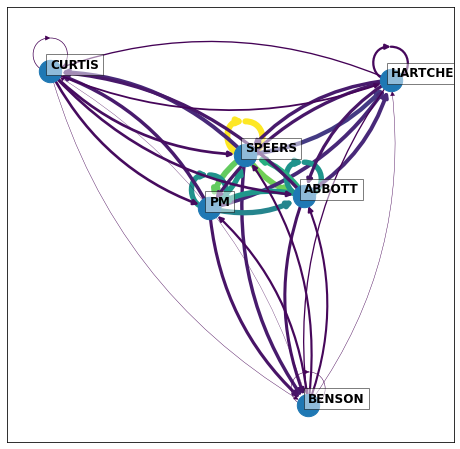

In [29]:
p2p_network = nx.from_pandas_adjacency(p2p_recurrence_raw, create_using=nx.DiGraph)
edge_weights = [weight for (a, b, weight) in p2p_network.edges.data("weight")]

fig, ax = plt.subplots()
fig.set_size_inches((8, 8))
# Draw the network
layout = nx.layout.spring_layout(p2p_network)
nx.draw_networkx(
    p2p_network,
    pos=layout,
    arrows=True,
    connectionstyle="arc3,rad=0.2",
    font_weight="bold",
    node_size=500,
    edge_cmap=cm.viridis,
    edge_color=edge_weights,
    width=[np.log(w) for w in edge_weights],
    bbox={"ec": "k", "fc": "white", "alpha": 0.5},
    verticalalignment="bottom",
    horizontalalignment="left",
)

As expected, the 3 central participants in the debate repeat each others' concept much more than the additional journalists.

## Visualizing similarity

The Discursis-style plot of similarity across the conversation is
available through `ConversationPlot`:

In [31]:
discursis_plot = ConversationPlot(conversation, similarity_matrix=concept_similarity)
discursis_plot.show()

While the default is to colour the plot by speakers, the more relevant column here 
is probably `"role"`, so we may want to use that from now on:

In [33]:
role_plot = ConversationPlot(
    conversation,
    similarity_matrix=concept_similarity,
    grouping_column="role",
    options={"show_help_text": False},
)
role_plot.show()

For more focussed exploration of the conversation, you can inspect a subset.
You can use the **Box Zoom** tool to zoom in on parts of the plot manually, however it may be better
to explicitly plot part of the conversation to focus on. 

You can also use the
`threshold` option to remove tiles with low similarity, to better highlight the utterances
that are similar:

In [35]:
focused_plot = ConversationPlot(
    conversation,
    similarity_matrix=concept_similarity.iloc[:25, :25],
    grouping_column="role",
    threshold=0.2,
)
focused_plot.show()